In [14]:
!pip install numpy pandas scikit-learn matplotlib seaborn statsmodels


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!pip install colorama lightgbm xgboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import glob
import datetime
import warnings
warnings.filterwarnings('ignore')

np.random.seed(7)
from colorama import Fore
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

### Merging All Zones Data

In [9]:
month_one = pd.read_csv("data/2025-04_1H_zone.csv")
month_two = pd.read_csv("data/2025-05_1H_zone.csv")
month_three = pd.read_csv("data/2025-06_1H_zone.csv")
month_four = pd.read_csv("data/2025-07_1H_zone.csv")
month_five = pd.read_csv("data/2025-08_1H_zone.csv")

all_months = pd.concat([month_one, month_two, month_three, month_four, month_five])
# dropping index column
all_months.drop("Unnamed: 0", axis=1, inplace=True)

# get zone wise different dataset
grouped = all_months.groupby(all_months.PUZone)
dfs = []
for i in range(0,73):
    dfs.append(grouped.get_group(i))
dfs[5].head(50)

PUZone  Count               PUTime
5          5      9  2025-04-01 00:00:00
78         5      4  2025-04-01 01:00:00
151        5      5  2025-04-01 02:00:00
224        5      8  2025-04-01 03:00:00
297        5      2  2025-04-01 04:00:00
370        5      1  2025-04-01 05:00:00
443        5      2  2025-04-01 06:00:00
516        5      0  2025-04-01 07:00:00
589        5      1  2025-04-01 08:00:00
662        5      4  2025-04-01 09:00:00
735        5      0  2025-04-01 10:00:00
808        5      3  2025-04-01 11:00:00
881        5      1  2025-04-01 12:00:00
954        5      0  2025-04-01 13:00:00
1027       5      0  2025-04-01 14:00:00
1100       5      0  2025-04-01 15:00:00
1173       5      1  2025-04-01 16:00:00
1246       5      1  2025-04-01 17:00:00
1319       5      0  2025-04-01 18:00:00
1392       5      0  2025-04-01 19:00:00
1465       5      0  2025-04-01 20:00:00
1538       5      0  2025-04-01 21:00:00
1611       5      0  2025-04-01 22:00:00
1684       5      0  2025-04-01 23:00:00
1757       5      2  2025-04-02 00:00:00
1830       5      0  2025-04-02 01:00:00
1903       5      1  2025-04-02 02:00:00
1976       5      0  2025-04-02 03:00:00
2049       5      0  2025-04-02 04:00:00
2122       5      0  2025-04-02 05:00:00
2195       5      0  2025-04-02 06:00:00
2268       5      0  2025-04-02 07:00:00
2341       5      0  2025-04-02 08:00:00
2414       5      0  2025-04-02 09:00:00
2487       5      0  2025-04-02 10:00:00
2560       5      1  2025-04-02 11:00:00
2633       5      0  2025-04-02 12:00:00
2706       5      0  2025-04-02 13:00:00
2779       5      1  2025-04-02 14:00:00
2852       5      0  2025-04-02 15:00:00
2925       5      0  2025-04-02 16:00:00
2998       5      0  2025-04-02 17:00:00
3071       5      1  2025-04-02 18:00:00
3144       5      0  2025-04-02 19:00:00
3217       5      0  2025-04-02 20:00:00
3290       5      1  2025-04-02 21:00:00
3363       5      1  2025-04-02 22:00:00
3436       5      0  2025-04-02 23:00:00
3509       5      0  2025-04-03 00:00:00
3582       5      1  2025-04-03 01:00:00

In [5]:
# Memory-efficient wide table creation using pivot
all_months['PUTime'] = pd.to_datetime(all_months['PUTime'])
# Downcast Count to int16 to save memory
all_months['Count'] = pd.to_numeric(all_months['Count'], downcast='integer')

# Aggregate duplicates by summing counts for each (PUTime, PUZone)
all_months_agg = all_months.groupby(['PUTime', 'PUZone'], as_index=False)['Count'].sum()

# Now pivot
zones_output = all_months_agg.pivot(index='PUTime', columns='PUZone', values='Count')
zones_output.columns = [f'Count_{i}' for i in zones_output.columns]
zones_output = zones_output.reset_index()

# Free up memory
import gc
del dfs
# del all_months  # Uncomment if you don't need all_months anymore
gc.collect()

print(zones_output.head())

               PUTime  Count_0  Count_1  Count_2  Count_3  Count_4  Count_5  \
0 2025-04-01 00:00:00       91      582      292      376       67        9   
1 2025-04-01 01:00:00      137      786      210      221      121        4   
2 2025-04-01 02:00:00      125      734      160      184      109        5   
3 2025-04-01 03:00:00      161      482      171      272       94        8   
4 2025-04-01 04:00:00      151      329      104      228       59        2   

   Count_6  Count_7  Count_8  ...  Count_63  Count_64  Count_65  Count_66  \
0        3        0       84  ...       294         8       617         2   
1        1        1      119  ...       302         8       556         4   
2        3        1      134  ...       269         4       463         5   
3        4        1       94  ...       235         4       404         6   
4        0        0       51  ...       153         3       385         3   

   Count_67  Count_68  Count_69  Count_70  Count_71  Count_72 

### High Traffic Zones

In [6]:
print(all_months.dtypes)
print("Non-numeric columns:", all_months.select_dtypes(exclude='number').columns.tolist())


PUZone             int64
Count              int16
PUTime    datetime64[ns]
dtype: object
Non-numeric columns: ['PUTime']


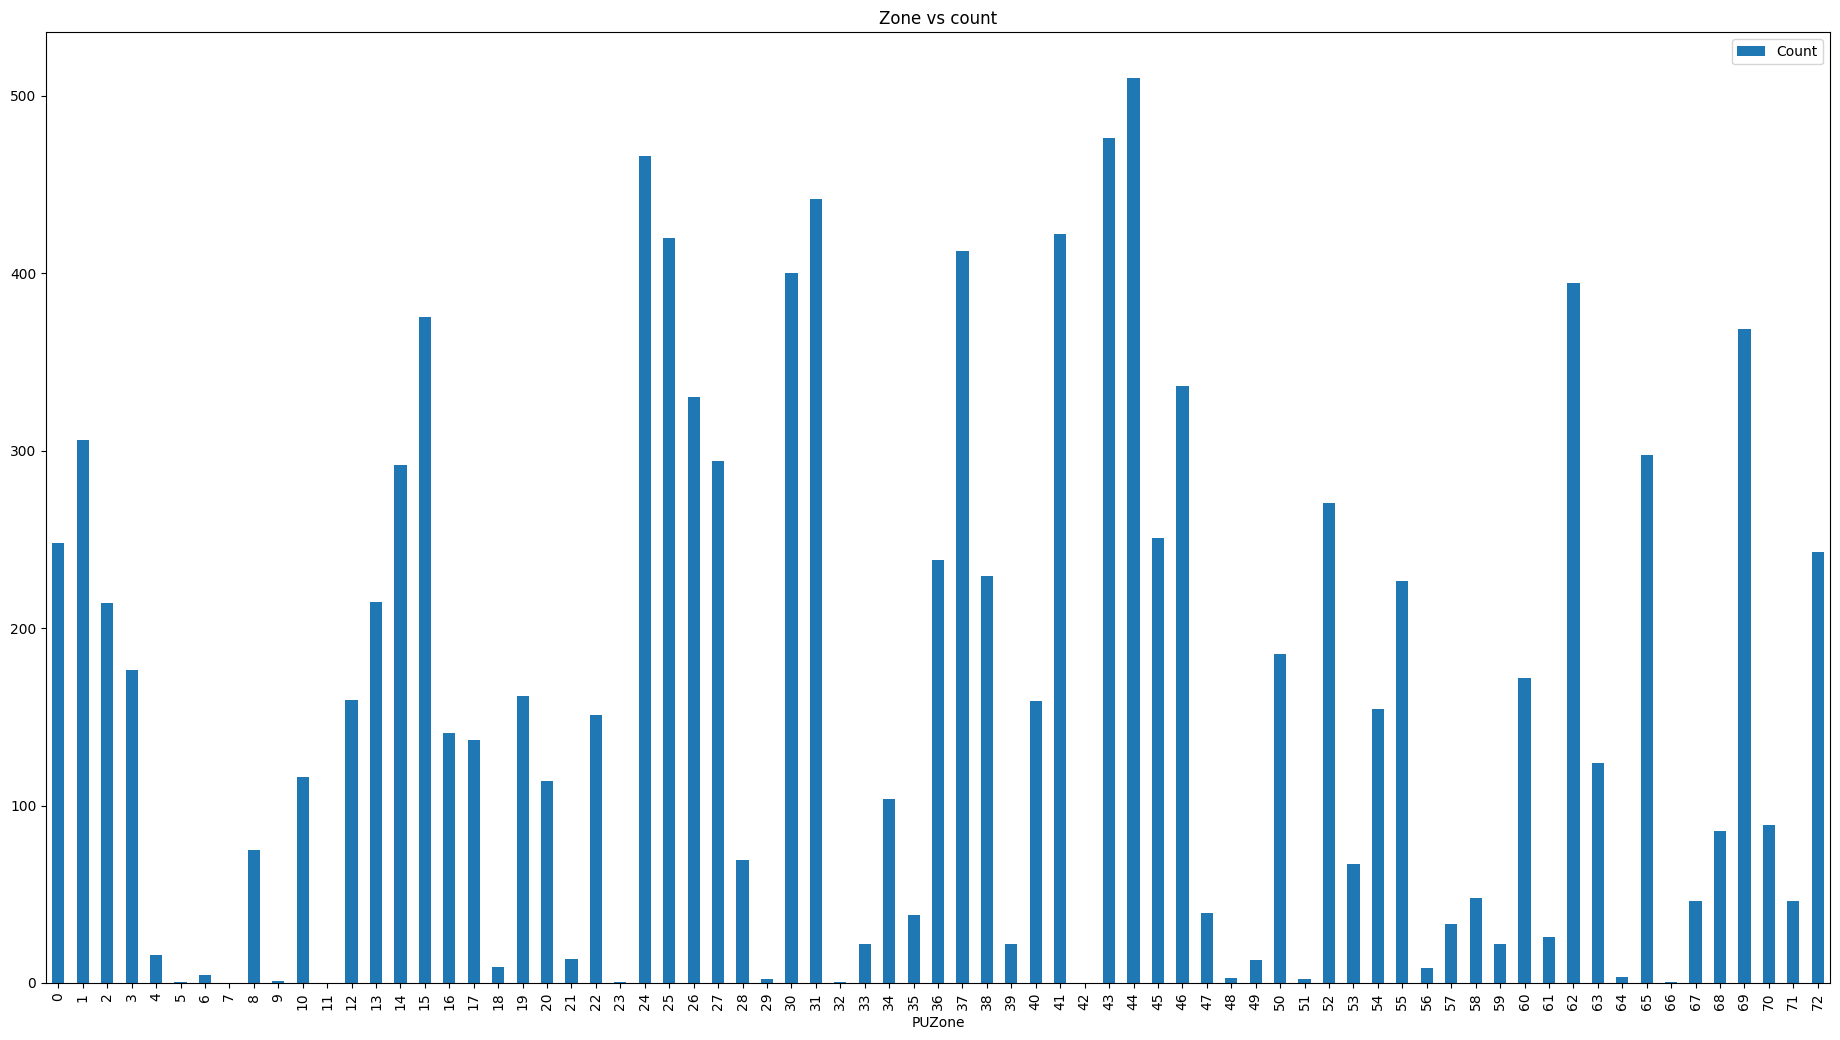

In [7]:
import matplotlib.pyplot as plt

# keep your flow, but ignore non-numeric columns when taking mean
all_months.groupby(["PUZone"]).mean(numeric_only=True).plot.bar()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("Zone vs count")
plt.tight_layout()
plt.show()

### Correlation Between Zones

In [ ]:
# Removed memory-inefficient merge loop. Use the new pivot-based approach from earlier cells instead.
# (This cell is intentionally left blank.)


MemoryError: Unable to allocate 3.38 GiB for an array with shape (18, 25169352) and data type int64

<Axes: >

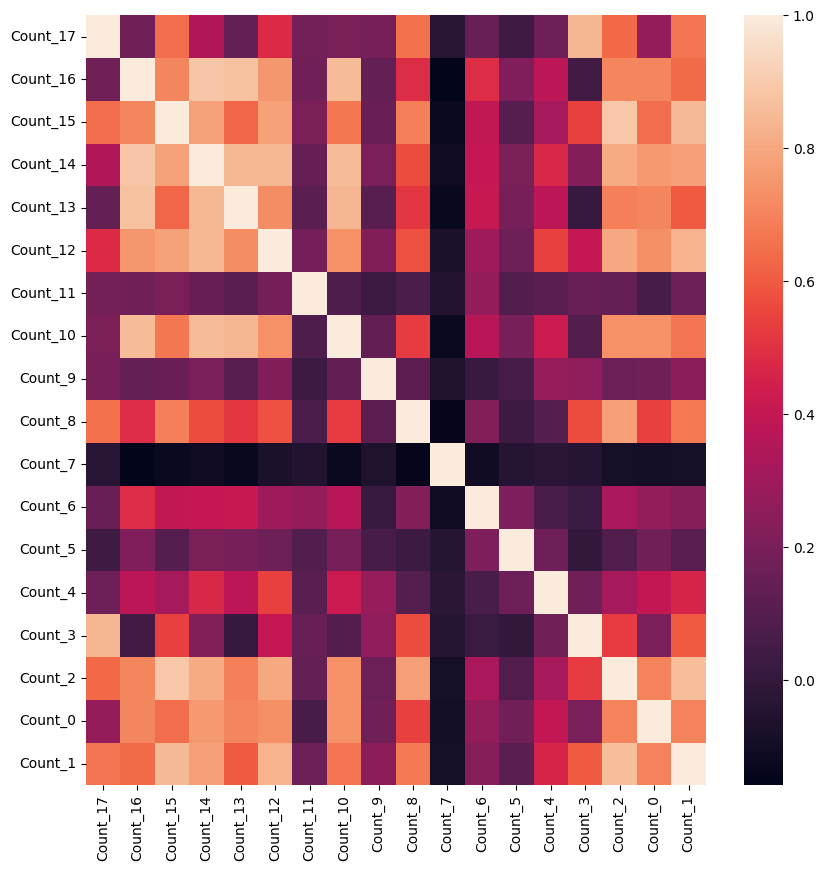

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

#Generating the correlation Matrix
corr = zones_output.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,ax = ax)

Get Zones with correlation over 0.8

In [12]:
#Fill an array with the value True of the size of columns
correlated_zones = {}
for i in range(73):
    correlated_zones[str(i)] = list()

#The matrix is symmetric.. M(i,j) = M(j,i) --> the features are the same for both
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.80:
            correlated_zones[str(i)].append(j)
import json
f = open('data/zone_neighbors.json')
a_json = json.loads(f.read())

lengths = [len(v) for v in a_json.values()]


all_zones = list(range(0, 73))

no_neighbours = [zone for zone in all_zones if str(zone) not in a_json.keys()]
print(no_neighbours)

[]


In [13]:
# Dictionary to hold neighbors
correlated_zones = {}
threshold = 0.8  # correlation cutoff

for i in range(corr.shape[0]):
    correlated_zones[str(i)] = []
    for j in range(corr.shape[0]):
        if i != j and corr.iloc[i, j] >= threshold:
            correlated_zones[str(i)].append(j)

# Print all zones and their neighbors
for zone, neighbors in correlated_zones.items():
    print(f"Zone {zone} → Neighbors: {neighbors}")


Zone 0 → Neighbors: [14]
Zone 1 → Neighbors: [3, 4, 7]
Zone 2 → Neighbors: [15, 17]
Zone 3 → Neighbors: [1, 4, 5, 7, 15]
Zone 4 → Neighbors: [1, 3, 7]
Zone 5 → Neighbors: [3, 15, 17]
Zone 6 → Neighbors: []
Zone 7 → Neighbors: [1, 3, 4]
Zone 8 → Neighbors: []
Zone 9 → Neighbors: []
Zone 10 → Neighbors: []
Zone 11 → Neighbors: []
Zone 12 → Neighbors: []
Zone 13 → Neighbors: []
Zone 14 → Neighbors: [0]
Zone 15 → Neighbors: [2, 3, 5, 17]
Zone 16 → Neighbors: []
Zone 17 → Neighbors: [2, 5, 15]


In [15]:
import json

# Dictionary to hold neighbors
correlated_zones = {}
threshold = 0.8  # correlation cutoff

for i in range(corr.shape[0]):
    correlated_zones[str(i)] = []
    for j in range(corr.shape[0]):
        if i != j and corr.iloc[i, j] >= threshold:
            correlated_zones[str(i)].append(j)

# Save as JSON file
with open("data/zone_neighbors.json", "w") as f:
    json.dump(correlated_zones, f, indent=4)

print("✅ Neighbor zones saved to zone_neighbors.json")


✅ Neighbor zones saved to zone_neighbors.json


In [16]:
# Load back from JSON
with open("data/zone_neighbors.json", "r") as f:
    neighbors = json.load(f)

# Print neighbors nicely
for zone, neigh_list in neighbors.items():
    print(f"Zone {zone} → Neighbors: {neigh_list}")


Zone 0 → Neighbors: [14]
Zone 1 → Neighbors: [3, 4, 7]
Zone 2 → Neighbors: [15, 17]
Zone 3 → Neighbors: [1, 4, 5, 7, 15]
Zone 4 → Neighbors: [1, 3, 7]
Zone 5 → Neighbors: [3, 15, 17]
Zone 6 → Neighbors: []
Zone 7 → Neighbors: [1, 3, 4]
Zone 8 → Neighbors: []
Zone 9 → Neighbors: []
Zone 10 → Neighbors: []
Zone 11 → Neighbors: []
Zone 12 → Neighbors: []
Zone 13 → Neighbors: []
Zone 14 → Neighbors: [0]
Zone 15 → Neighbors: [2, 3, 5, 17]
Zone 16 → Neighbors: []
Zone 17 → Neighbors: [2, 5, 15]


**18 & 32 have no neighbour**

### Intersection between neighbours and maximum correlated zones

In [ ]:
intersecting_zones = {}
for i in range(73):
    key = str(i)
    # Get correlated zones as strings for comparison with JSON  
    correlated = [str(z) for z in correlated_zones.get(key, [])]
    neighbors = set(a_json.get(key, []))
    intersecting_zones[key] = [z for z in correlated if z in neighbors]

print(intersecting_zones)

{'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': [], '16': [], '17': [], '18': [], '19': [], '20': [], '21': [], '22': [], '23': [], '24': [], '25': [], '26': [], '27': [], '28': [], '29': [], '30': [], '31': [], '32': [], '33': [], '34': [], '35': [], '36': [], '37': [], '38': [], '39': [], '40': [], '41': [], '42': [], '43': [], '44': [], '45': [], '46': [], '47': [], '48': [], '49': [], '50': [], '51': [], '52': [], '53': [], '54': [], '55': [], '56': [], '57': [], '58': [], '59': [], '60': [], '61': [], '62': [], '63': [], '64': [], '65': [], '66': [], '67': [], '68': [], '69': [], '70': [], '71': [], '72': []}


Low correlation with neighbours for most

### TRIP COUNT

**ACF AND PACF Plots**

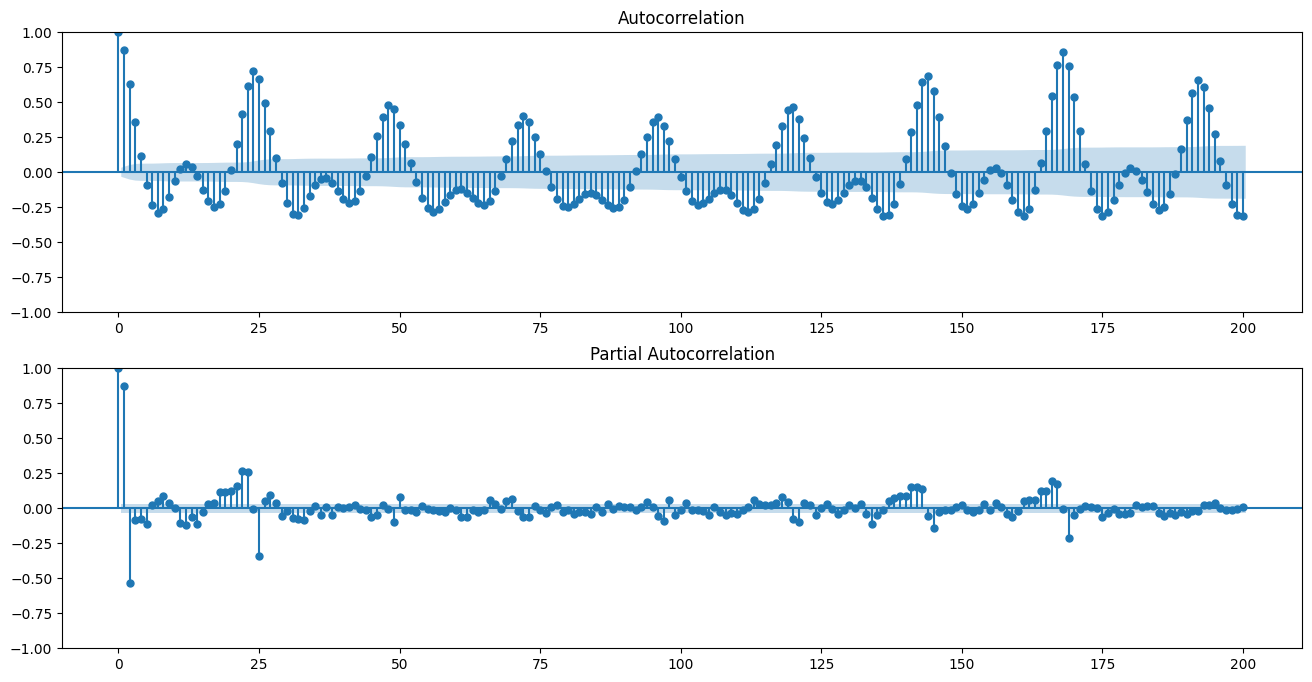

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(dfs[1]['Count'], lags=200, ax=ax[0])
plot_pacf(dfs[1]['Count'], lags=200, ax=ax[1])
plt.show()

### PEAK TIME DETECTION

2017-01-31 ; Weekday :  True


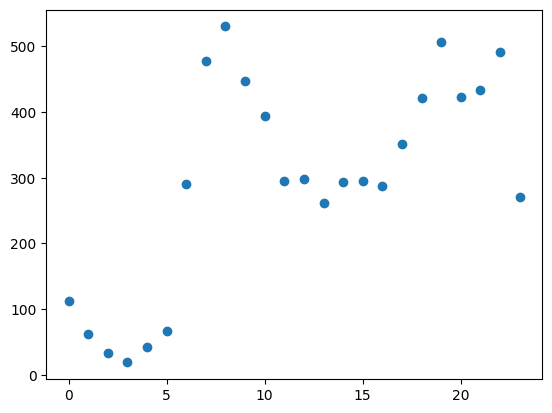

2017-02-01 ; Weekday :  True


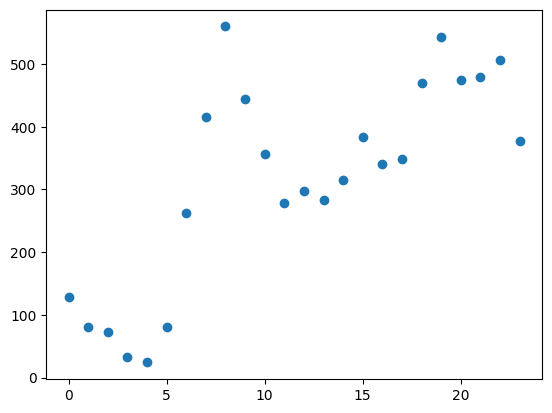

2017-02-02 ; Weekday :  True


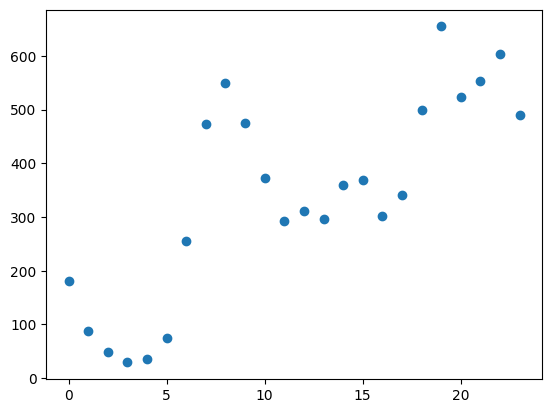

2017-02-03 ; Weekday :  True


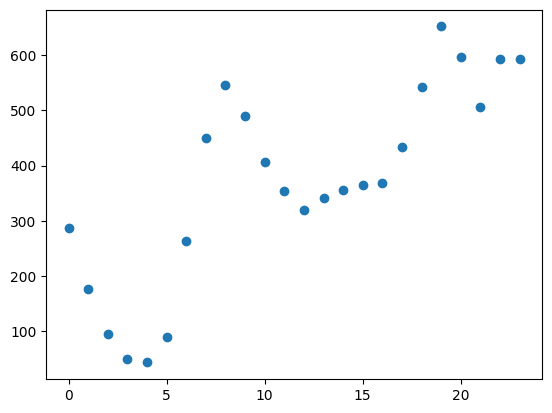

2017-02-04 ; Weekday :  False


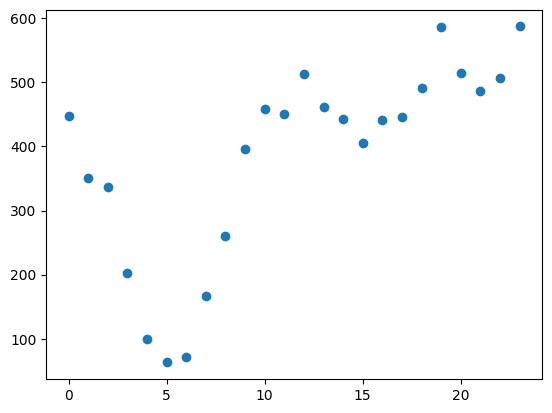

2017-02-05 ; Weekday :  False


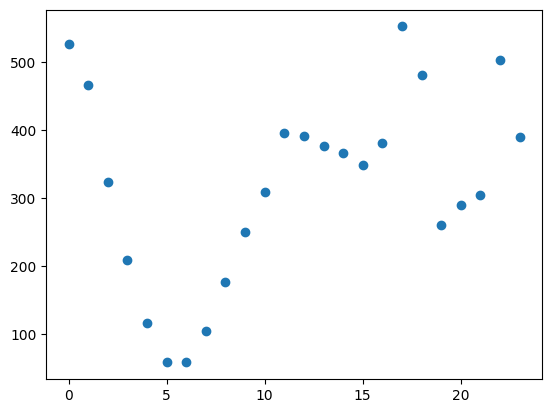

2017-02-06 ; Weekday :  True


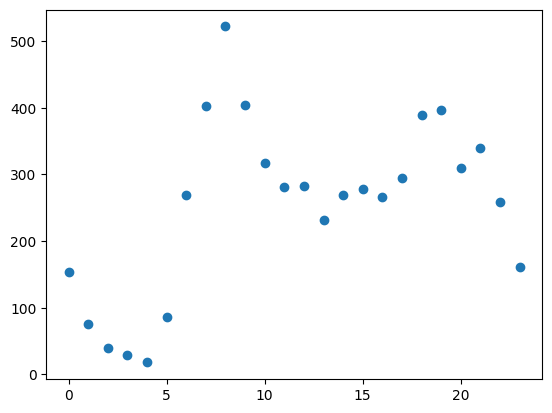

2017-02-07 ; Weekday :  True


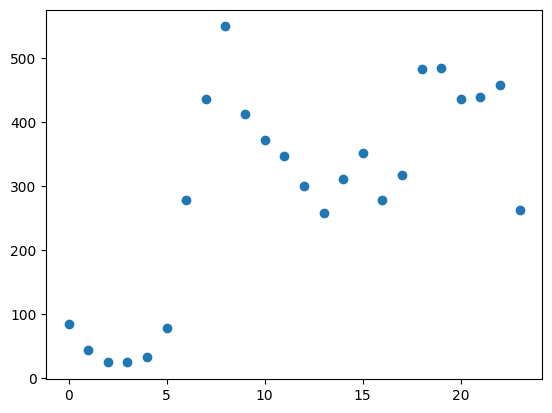

2017-02-08 ; Weekday :  True


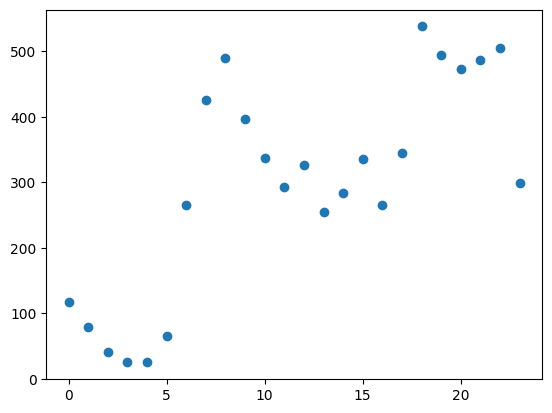

2017-02-09 ; Weekday :  True


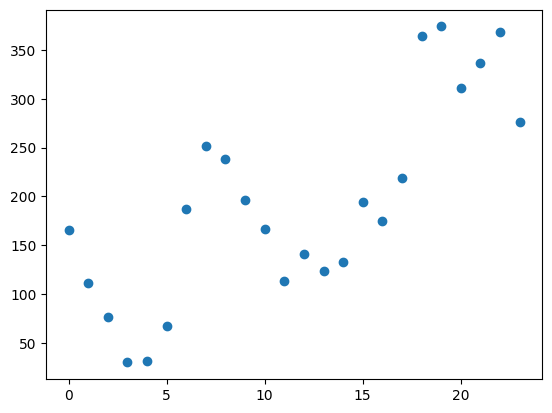

2017-02-10 ; Weekday :  True


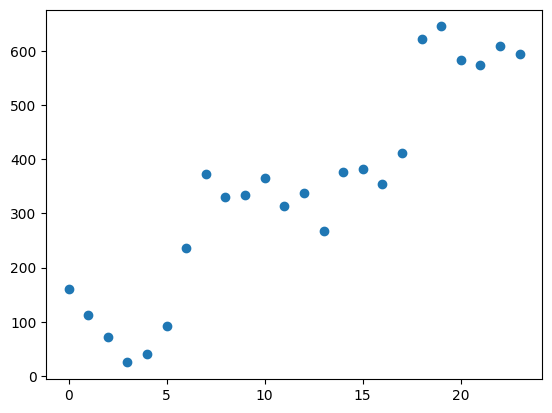

2017-02-11 ; Weekday :  False


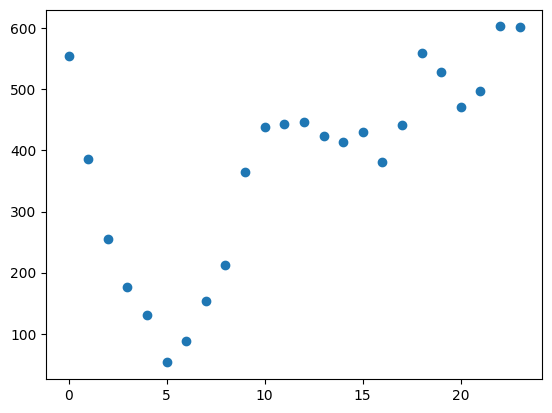

2017-02-12 ; Weekday :  False


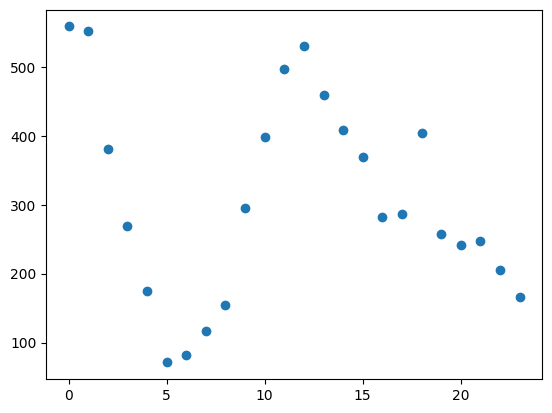

2017-02-13 ; Weekday :  True


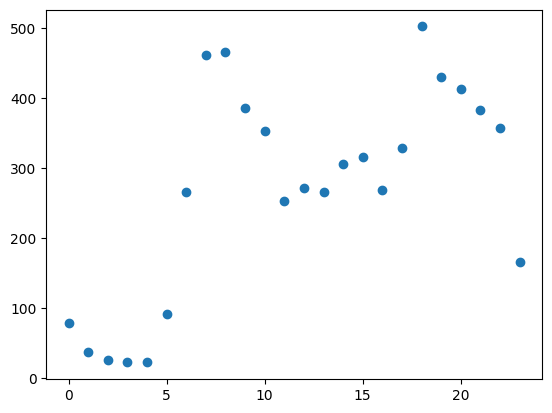

In [ ]:
import matplotlib.pyplot as plt
num = 0

dfs[1]['PUTime'] = pd.to_datetime(dfs[1]['PUTime'])
dfs[1]['date'] = dfs[1]['PUTime'].dt.date

for i in range(14):
    zone_zero = dfs[1]
    one_date = zone_zero.iloc[i*24 + (24*30)]['date']
    day_of_week = zone_zero.iloc[i*24 + (24*30)]['PUTime'].dayofweek < 5
    print(one_date, "; Weekday : ", day_of_week)
    zone_zero = zone_zero[ ( zone_zero['date']  == one_date ) ]
    zone_zero["Time"] = zone_zero["PUTime"].dt.hour


    plt.scatter(zone_zero['Time'], zone_zero['Count'])
    plt.show() # Depending on whether you use IPython or interactive mode, etc.

#     plt.savefig("zone_zero_" + str(one_date) + "_" + str(day_of_week) + ".png")
    num = num + 1

**Weekday Peak Time**  :

1. 6-10     

2. 16-20

**Weekend Peak Time**  :

1. 16-20

### Weather Data

Missing data has been replaced with 0.

In [ ]:
weather = pd.read_csv('/content/data/weather.csv')
weather_columns = ['date', 'avg_wind_speed', 'peak_gust_time', 'precipitation', 'snow', 'snow_depth', 'temp_avg', 'temp_max', 'temp_min', 'tot_sunshine',
                  'dir_fwind_2min', 'dir_fwind_5min', 'speed_fwind_2min', 'speed_fwind_5min', 'fog', 'heavy_fog', 'thunder', 'ice_pellets', 'hail', 'glaze', 'smoke']
weather.columns = weather_columns
weather['date'] = pd.DatetimeIndex(weather['date']).date
weather = weather.dropna(how='all')
weather = weather.drop(['peak_gust_time', 'temp_avg', 'tot_sunshine', 'thunder', 'ice_pellets', 'hail', 'glaze'], axis=1)
### replace with 0
weather['fog'] = weather['fog'].fillna(0)
weather['smoke'] = weather['smoke'].fillna(0)
weather['heavy_fog'] = weather['heavy_fog'].fillna(0)
weather['dir_fwind_5min'] = weather['dir_fwind_5min'].interpolate(method='polynomial', order=2).fillna(0)
weather['speed_fwind_5min'] = weather['speed_fwind_5min'].interpolate(method='polynomial', order=2).fillna(0)

In [ ]:
weather_data = weather.copy()

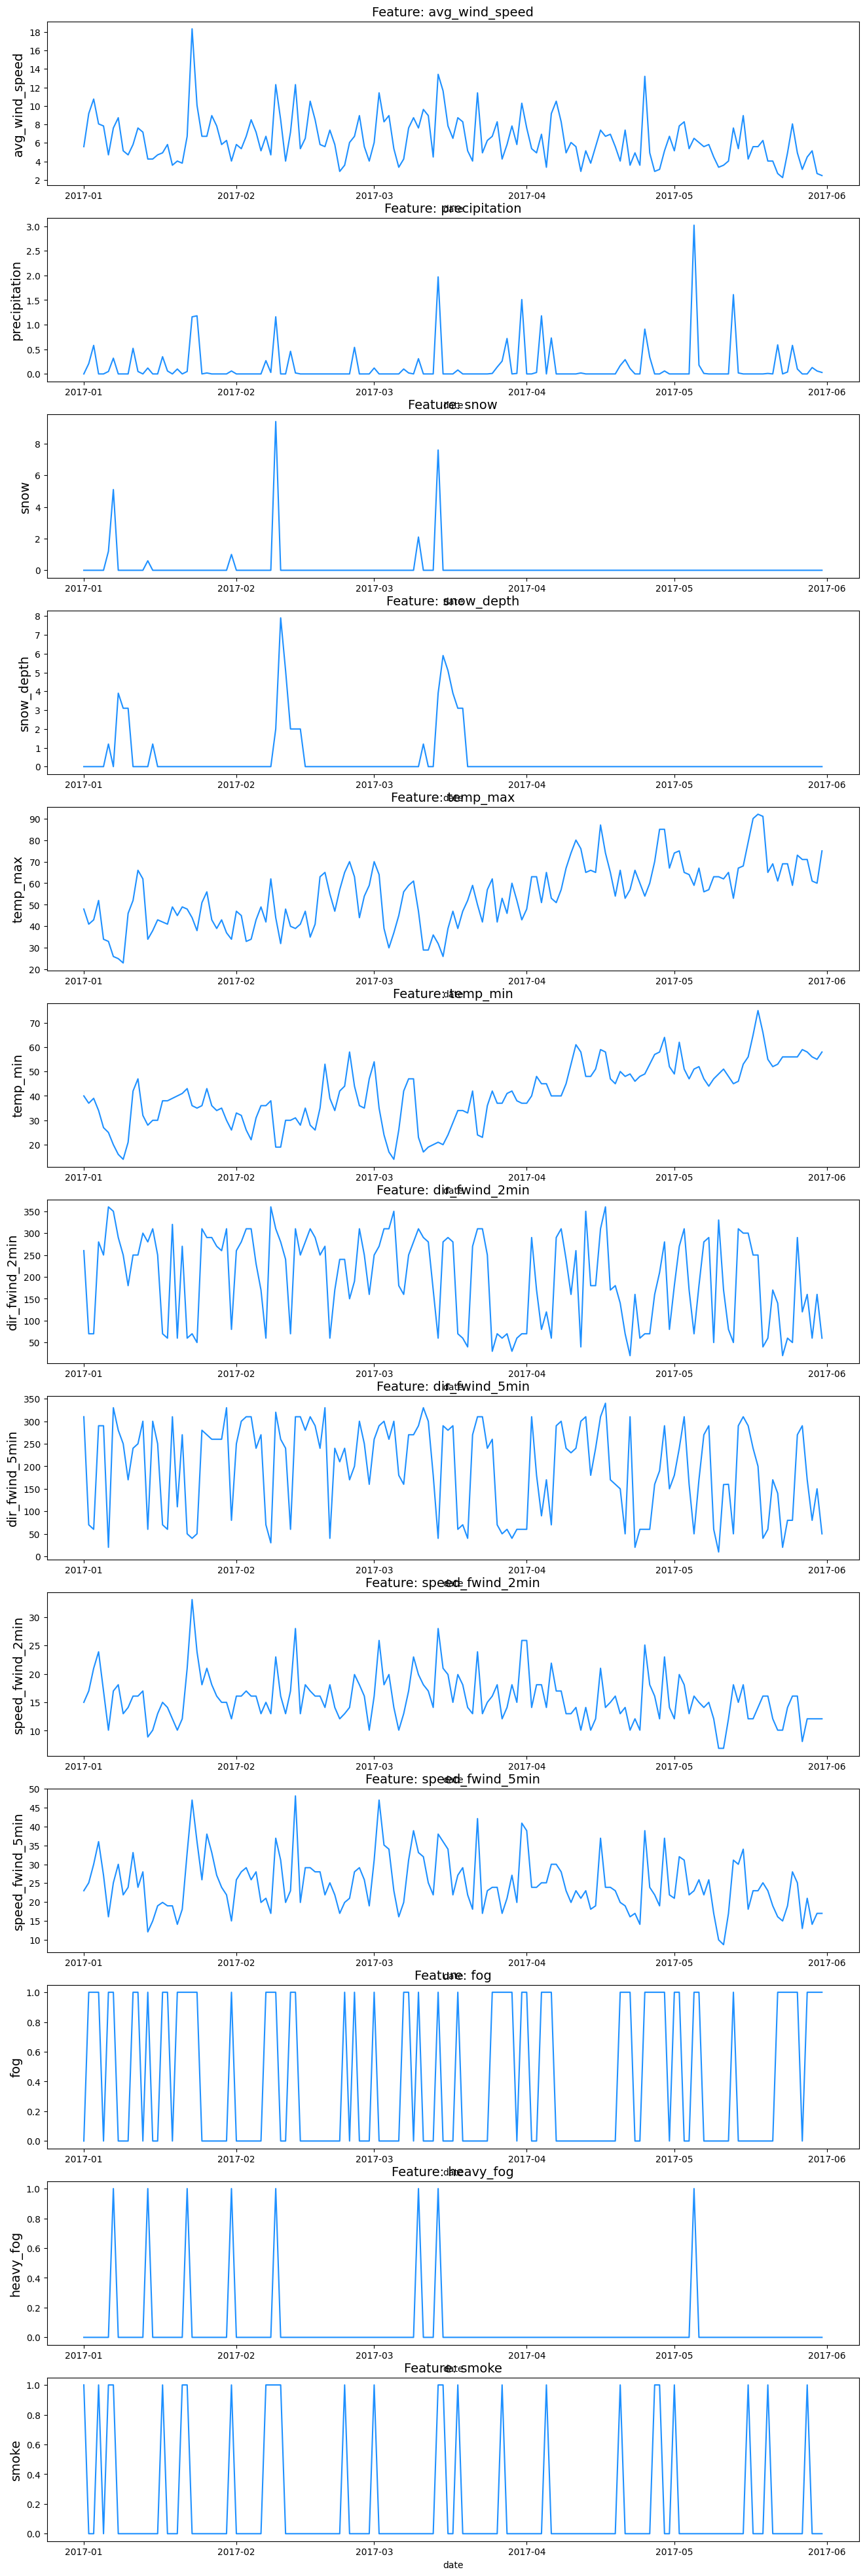

In [ ]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=13, ncols=1, figsize=(16, 50))

for i, column in enumerate(weather_data.drop('date', axis=1).columns):
#     print(column)
    sns.lineplot(x=weather_data['date'], y=weather_data[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

### Seasonal Decompose

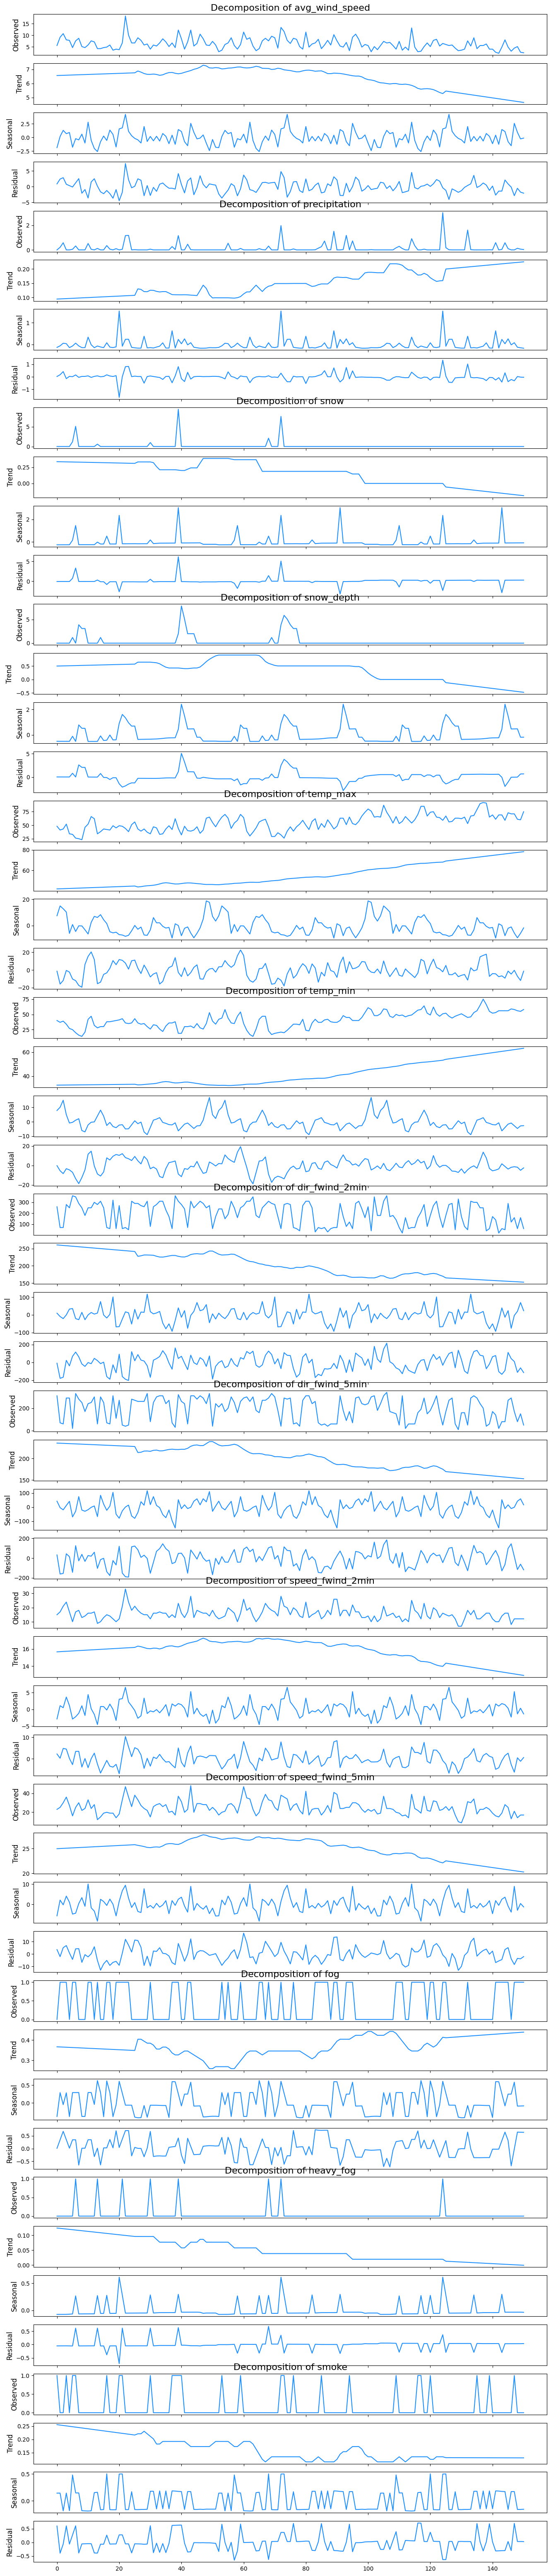

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'avg_wind_speed', 'precipitation', 'snow', 'snow_depth',
    'temp_max', 'temp_min', 'dir_fwind_2min', 'dir_fwind_5min',
    'speed_fwind_2min', 'speed_fwind_5min', 'fog',
    'heavy_fog', 'smoke'
]

for column in core_columns:
    decomp = seasonal_decompose(weather_data[column], period=52, model='additive', extrapolate_trend='freq')
    weather_data[f"{column}_trend"] = decomp.trend
    weather_data[f"{column}_seasonal"] = decomp.seasonal
fig, ax = plt.subplots(ncols=1, nrows=4*len(core_columns), sharex=True, figsize=(16,80))
row_no = 0
for i, column in enumerate(core_columns):

    res = seasonal_decompose(weather_data[column], period=52, model='additive', extrapolate_trend='freq')

    ax[row_no].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[row_no], legend=False, color='dodgerblue')
    ax[row_no].set_ylabel('Observed', fontsize=12)
    row_no = row_no + 1

    res.trend.plot(ax=ax[row_no], legend=False, color='dodgerblue')
    ax[row_no].set_ylabel('Trend', fontsize=12)
    row_no = row_no + 1

    res.seasonal.plot(ax=ax[row_no], legend=False, color='dodgerblue')
    ax[row_no].set_ylabel('Seasonal', fontsize=12)
    row_no = row_no + 1

    res.resid.plot(ax=ax[row_no], legend=False, color='dodgerblue')
    ax[row_no].set_ylabel('Residual', fontsize=12)
    row_no = row_no + 1

plt.show()

### Correlation of Weather Features

Text(0.5, 1.0, 'Correlation Matrix of Core Features')

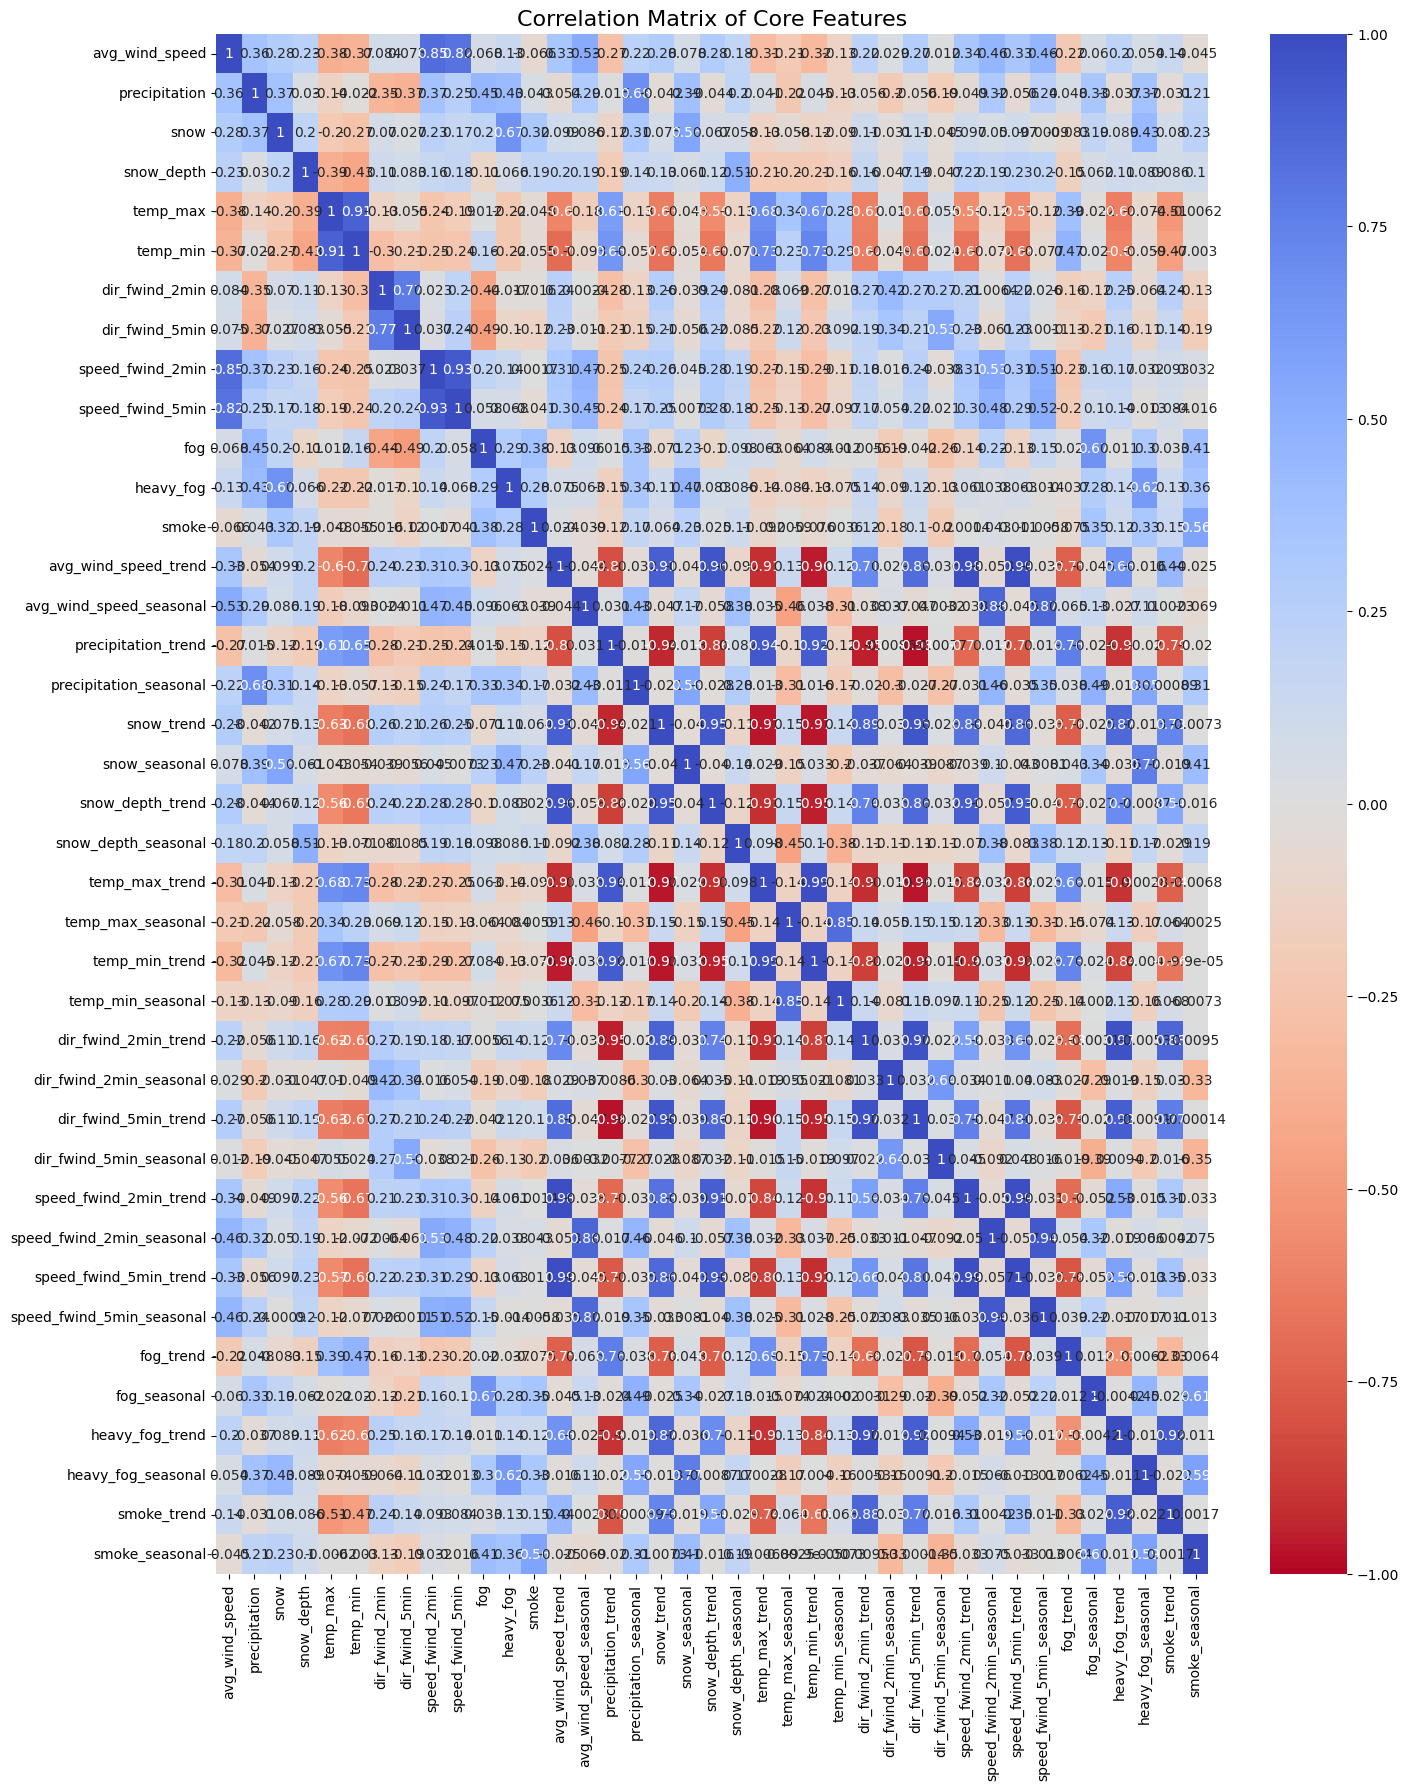

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 20))

corrmat = weather_data.corr(numeric_only=True)

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax)
ax.set_title('Correlation Matrix of Core Features', fontsize=16)

### Correlation of Lagging Weather Features with Trip Count

In [ ]:
df = pd.concat(map(pd.read_csv, ['/content/data/2017-01_1H_zone.csv', '/content/data/2017-02_1H_zone.csv','/content/data/2017-03_1H_zone.csv',
                                '/content/data/2017-04_1H_zone.csv','/content/data/2017-05_1H_zone.csv']))
df.drop(['Unnamed: 0'], axis=1,inplace=True)
df['PUTime'] = pd.to_datetime(df['PUTime'])
df['date'] = df['PUTime'].dt.date
df['hour'] = df['PUTime'].dt.hour

avg_wind_speed


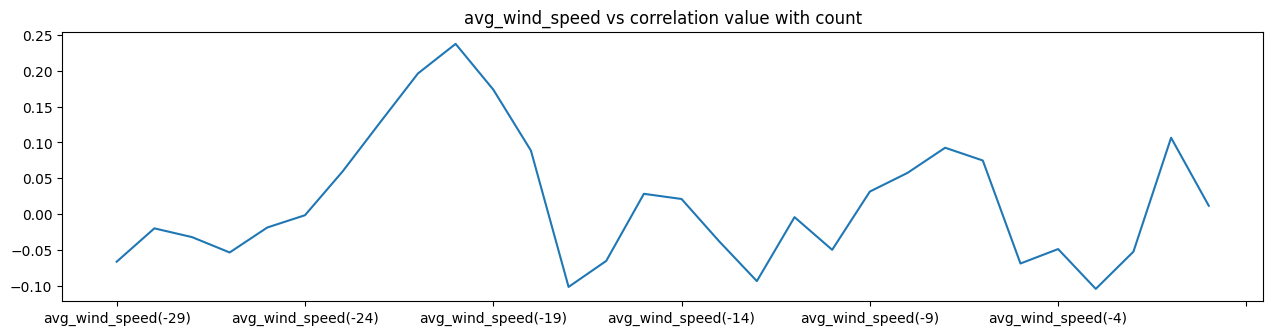

precipitation


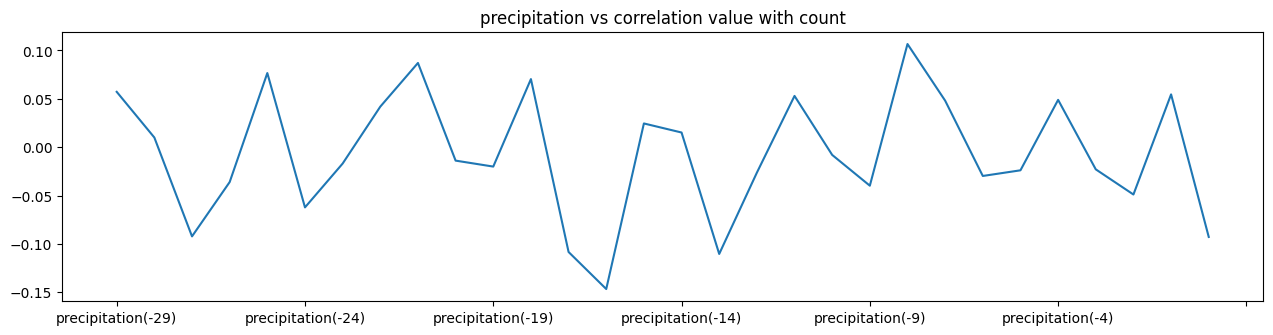

snow


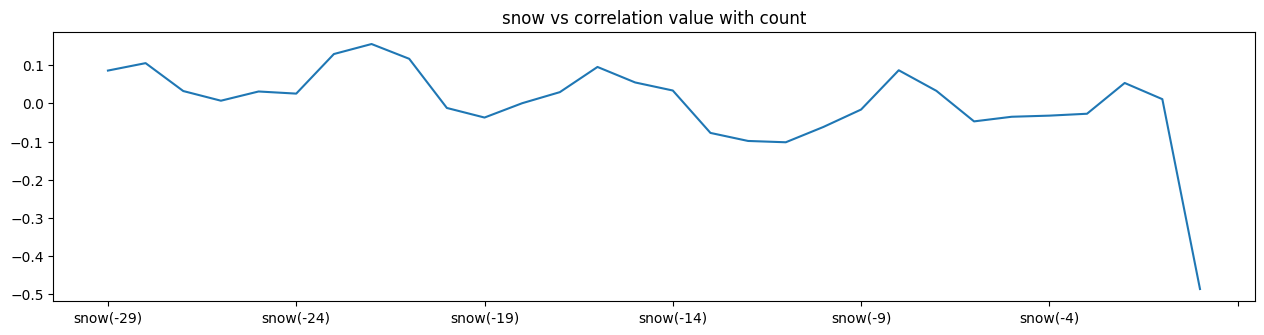

snow_depth


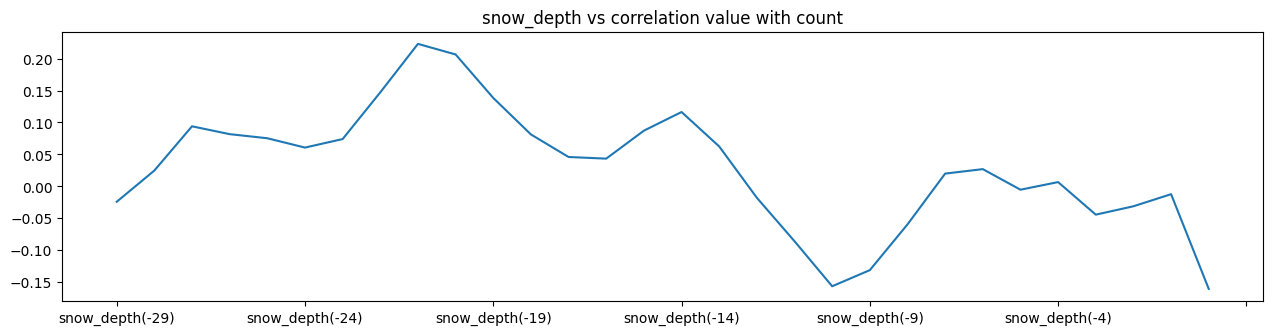

temp_max


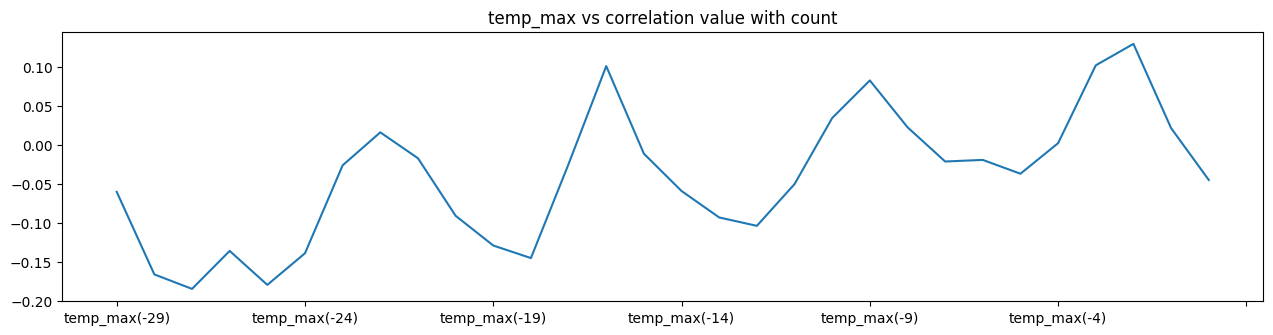

temp_min


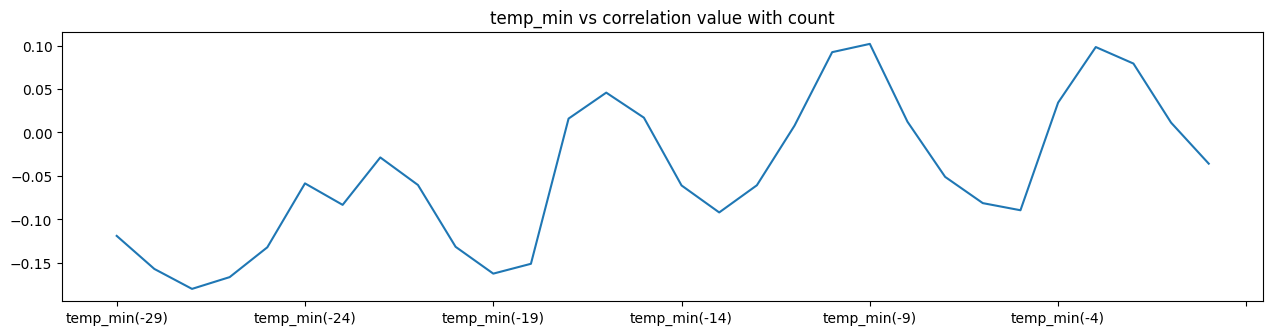

dir_fwind_2min


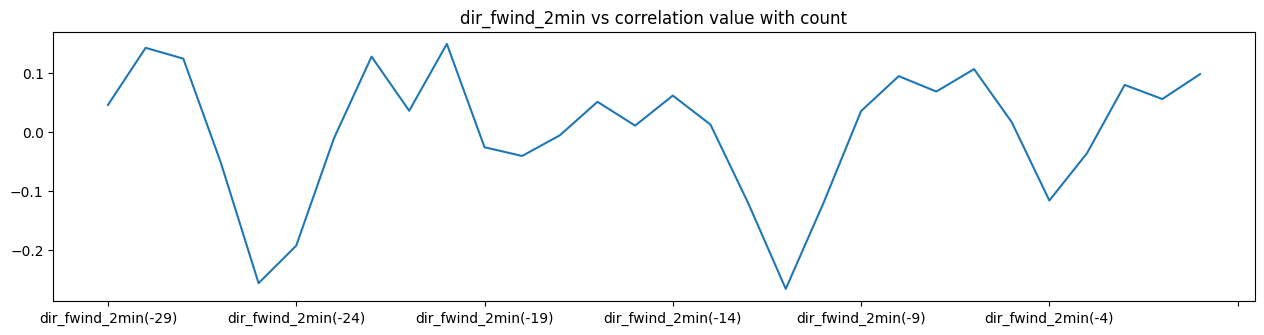

dir_fwind_5min


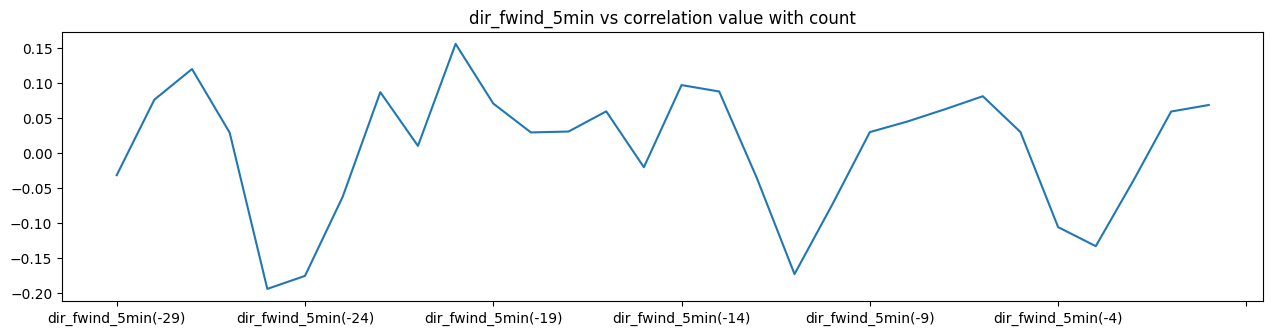

speed_fwind_2min


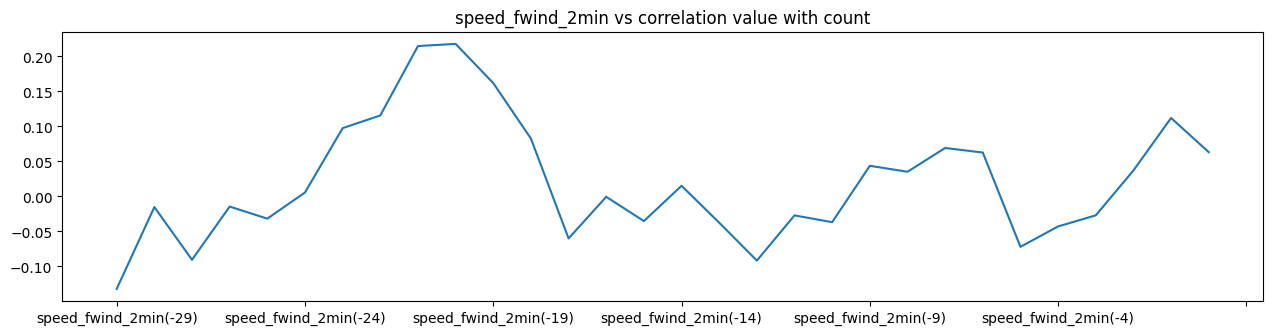

speed_fwind_5min


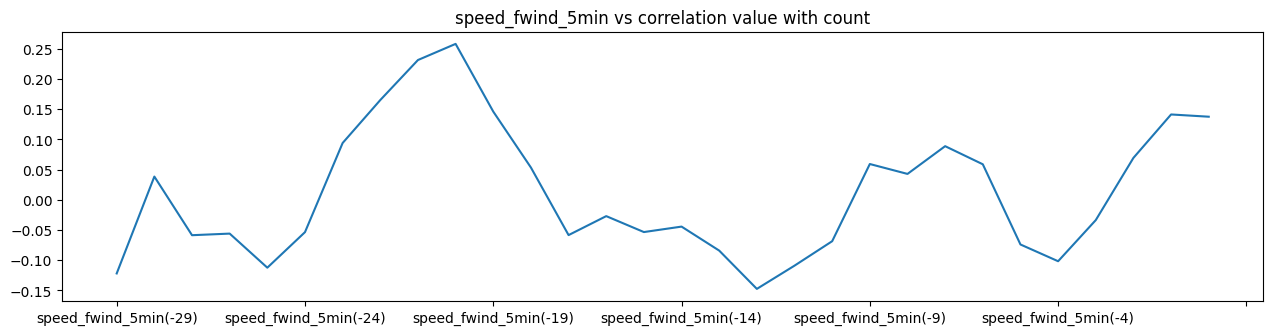

fog


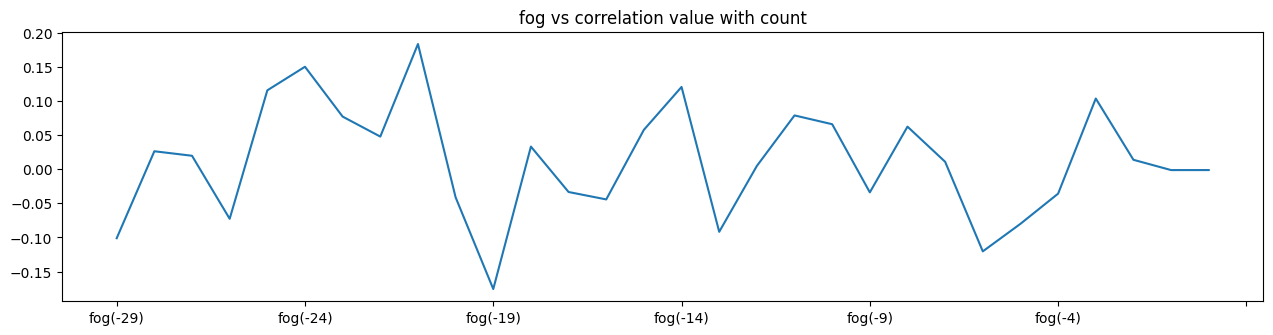

heavy_fog


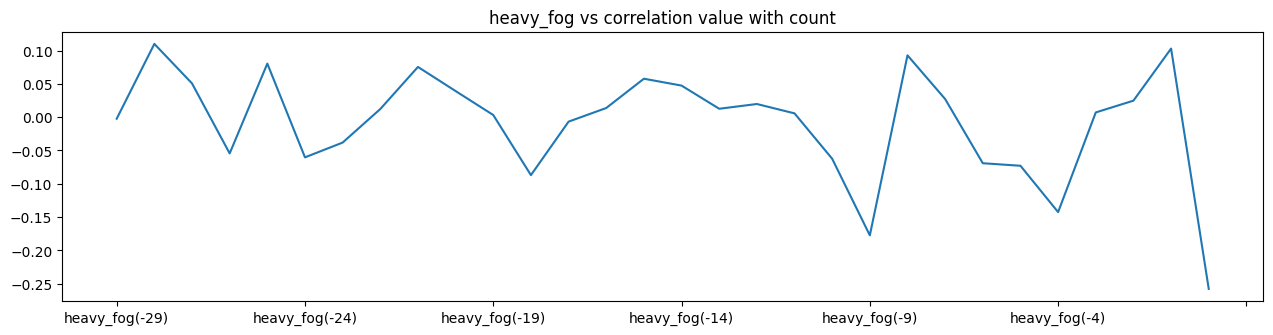

smoke


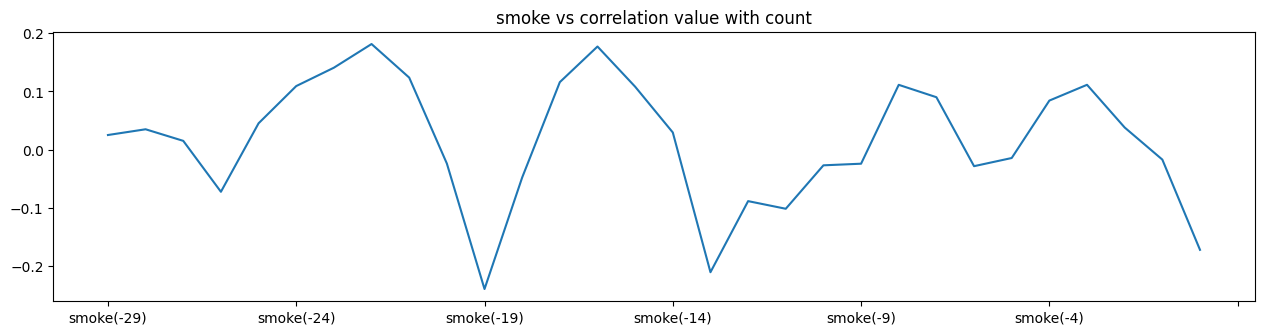

In [ ]:
df['date'] = df['date'].astype(str)
weather['date'] = weather['date'].astype(str)
dfw = df.merge(weather, on='date')
keep_columns = ['Count','hour','date',
       'avg_wind_speed', 'precipitation', 'snow', 'snow_depth', 'temp_max',
       'temp_min', 'dir_fwind_2min', 'dir_fwind_5min', 'speed_fwind_2min',
       'speed_fwind_5min', 'fog', 'heavy_fog', 'smoke','PUZone']

dfAll3 = dfw.filter(keep_columns)
dfw_z = dfAll3.groupby(["date"]).mean()
for weather_param in dfw_z.columns.to_list():
    indexed_df = dfw_z.copy()
    indexed_df = indexed_df.filter([weather_param],axis=1)
    n_steps_in = 30
    dfw_z_new = pd.DataFrame()
    for k in range(len(indexed_df.columns)) :
        for i in range(n_steps_in):
            dfw_z_new[indexed_df.columns[k] + '(' + str(-i) + ')'] = indexed_df.iloc[:,k].shift(i)
    #             if i<=4 :
    #                 X_new[indexed_df.columns[k] + '(' + str(-24*7*i) + ')'] = indexed_df.iloc[:,k].shift(24*7*i)
    dfw_z_new = dfw_z_new.iloc[:, ::-1]
    dfw_z_new['Count'] = dfw_z['Count'].values
    dfw_z_new = dfw_z_new.dropna()
    if weather_param=='Count' or weather_param=='hour' or weather_param=='PUZone' :
        continue
    print(weather_param)
#     print(type(dfw_z_new.corr().iloc[30,:]))
    dfw_z_new.corr().iloc[30,:-1].plot()
    fig = plt.gcf()
    fig.set_size_inches(15.5, 3.5)
    plt.title(weather_param+' vs correlation value with count')
    plt.show()
#     plt.tick_params(axis='x', which='major', labelsize=4)
    plt.clf

In [ ]:
# View first 5 rows
print(df.head())


   PUZone  Count     PUTime        date  hour
0       0     91 2017-01-01  2017-01-01     0
1       1    582 2017-01-01  2017-01-01     0
2       2    292 2017-01-01  2017-01-01     0
3       3    376 2017-01-01  2017-01-01     0
4       4     67 2017-01-01  2017-01-01     0


## Findings
* There are some noticeable seasonality here
* However, all of the correlation values of weather parameters with today's count are very low
* So we could concur that trip count does not have significant dependency with past month's weather